# Выбор локации для скважины

## Описание проекта

### Цель проекта

Необходимо решить, где бурить новую скважину для добычи нефти. Заказчик - нефтедобывающая компания. 

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### Исходные данные

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Построим модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой Bootstrap.

Компания-заказчик пердоставила данные геологоразведки трёх регионов в виде трёх файлов формата .csv:
- `geo_data_0.csv`
- `geo_data_1.csv`
- `geo_data_2.csv`

Данные содержат следующую информацию:
- `'id'` — уникальный идентификатор скважины;
- `'f0'`, `'f1'`, `'f2'` — три значимых признака точек;
- `'product'` — объём запасов в скважине (тыс. баррелей).

### Этапы проекта

Шаги для выбора локации:

- В избранном регионе собираем характеристики для скважин: качество нефти и объём её запасов;
- Строим модель для предсказания объёма запасов в новых скважинах;
- Выбираем скважины с самыми высокими оценками значений;
- Определяем регион с максимальной суммарной прибылью отобранных скважин.

О качестве данных ничего не известно. Перед тем как приступить к разработке модели машинного обучения, понадобится обзор данных и, при необходимости, предобработка.

Таким образом проект пройдет в следующие этапы:

- Загрузка и подготовка данных.
- Исследовательский анализ данных.
- Коррелящтонный анализ.
- Обучение и проверка модели для каждого региона.
- Подготовка к расчёту прибыли.
- Расчёт прибыли и рисков.
- Общий вывод.

## Загрузка и подготовка данных

### Подготовка библиотек и загрузка данных

In [1]:
# библиотеки и обновления, установленные на сервере самостоятельно, слетают, поэтому ячейка всегда активна.
!pip install -U scikit-learn
!pip install -U datashader
!pip install phik
!pip install tabulate 


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
## импортируем необходимые библиотеки----------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tabulate import tabulate
import warnings
np.warnings = warnings

## из библиотек импортируем необходимые функции и классы---------------------------------
from scipy import stats as st
from matplotlib.pyplot import figure
from math import factorial, sqrt

# загружаем функции
from sklearn.model_selection import train_test_split
from scipy.stats import binom, norm
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from pandas.plotting import scatter_matrix

# загружаем классы моделей
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import LinearRegression

# загружаем классы для преобразования данных
from sklearn.preprocessing import StandardScaler

# загружаем метрики
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error, 
    r2_score,
    accuracy_score,
    confusion_matrix,
    recall_score, 
    precision_score,
    roc_auc_score,
    make_scorer # создание пользовательской метрики
)

## константы----------------------------------------------------------------------------

# константа для фиксации данных при обучении моделей, чтобы получать одинаковые результаты при пересчёте
RANDOM_STATE = 42  

# размер тестовой выборки
TEST_SIZE = 0.25   

# бюджет на разработку скважин, руб.
BUDGET = 10**10

# количество разрабатываемых скважин на регион
NUM_WELLS = 200

# цена тысячи баррелей, руб.
PRICE_THOUSAND_BARRELS = 450000

Cоздадим датафреймы из файлов .csv и присвоим им номер в соответствии с исходными данными заказчика, например: `df_0`.

In [3]:
# загружаем данные геологоразведки для трёх регионов и создаем датафреймы pandas
df_0 = pd.read_csv('geo_data_0.csv')
df_1 = pd.read_csv('geo_data_1.csv')
df_2 = pd.read_csv('geo_data_2.csv')

- Данные загружены в датафреймы.
- Ошибок не обнаружено.

### Получение общей информации о данных

Выведем первые строки созданных датафреймов и общую информацию.

In [4]:
# создадим функцию для вывода первых строк и общей информации для датафреймов
def df_head_info(df):
    # извлекаем имя датафрейма
    name =[x for x in globals() if globals()[x] is df][0]
    
    # выводим первые строки и общую информацию
    print(f'Датафрейм "{name}":\n', df.head(), '\n')
    print(df.info(), '\n\n')

# выведем первые строки и имена датафреймов
for i in [df_0, df_1, df_2]:
    df_head_info(i)

Датафрейм "df_0":
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 


Датафрейм "df_1":
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305


**Вывод:**
- Во всех 3-х датафреймах по 100 тыс. значений.
- Пропуски не обнаружены.
- Значения столбцов `id` представлены шифром из латинских букв в разных регистрах и цирф. 

Данные выглядят корректными.

### Проверка на дубликаты

Проверим данные на наличие явных и неявных дубликатов.

**Проверка на явные дубликаты.**

In [5]:
print(df_0.duplicated().sum())
print(df_1.duplicated().sum())
print(df_2.duplicated().sum())

0
0
0


Во всех датафреймах явных дубликатов не обнарудено.

**Проверка на неявные дубликаты.**

Проверим датафреймы на дублирующиеся значения в столбцaх `'id'`.

In [6]:
df_0['id'].value_counts().count()

99990

В датафрейме df_0 есть 10 дубликатов в значениях столбца `'id'`.

In [7]:
# создадим список дубликатов для df_0
dupl_id_0 = df_0[df_0['id'].duplicated()]['id'].tolist()

# выведем все дубликаты
df_0[df_0['id'].isin(dupl_id_0)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [8]:
df_1['id'].value_counts().count()

99996

В датафрейме df_1 есть 4 дубликата в значениях столбца `'id'`.

In [9]:
# создадим список дубликатов для df_1
dupl_id_1 = df_1[df_1['id'].duplicated()]['id'].tolist()

# выведем все дубликаты
df_1[df_1['id'].isin(dupl_id_1)].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [10]:
df_2['id'].value_counts().count()

99996

В датафрейме df_2 есть 4 дубликата в значениях столбца `'id'`.

In [11]:
# создадим список дубликатов для df_2
dupl_id_2 = df_2[df_2['id'].duplicated()]['id'].tolist()

# выведем все дубликаты
df_2[df_2['id'].isin(dupl_id_2)].sort_values('id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


**Вывод:**

В значениях столбцов `'id'` обнаружены дубликаты во всех 3-х датафреймах. Поскольку дубликатов немного, а признаки в дубликатах различаются сильно, удалим данные строки.

### Обработка дубликатов

Удалим строки с дублирующимися `'id'` в датфреймах `df_0`, `df_1`, `df_2`.

In [12]:
df_0 = df_0.drop_duplicates(subset=['id'], keep=False)
df_1 = df_1.drop_duplicates(subset=['id'], keep=False)
df_2 = df_2.drop_duplicates(subset=['id'], keep=False)

In [14]:
# проверим датафреймы на дубликаты в столбцах 'id'
for i in [df_0, df_1, df_2]:
    print(i['id'].value_counts().count())

99980
99992
99992


Выведем первые строки и общую информацию о датафреймах.

In [15]:
for i in [df_0, df_1, df_2]:
    df_head_info(i)

Датафрейм "df_0":
       id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99980 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99980 non-null  object 
 1   f0       99980 non-null  float64
 2   f1       99980 non-null  float64
 3   f2       99980 non-null  float64
 4   product  99980 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB
None 


Датафрейм "df_1":
       id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ

**Вывод:**

- Строки, содержащие дублирующиеся id удалены.
- Данные корректны, ошибок не обнаружено.

## Исследовательский анализ данных

### Анализ признаков

Исследуем данные датафреймов `df_0`, `df_1`, `df_2`.

In [16]:
# создадим функцию для построения графиков
def hist(col, bins, title, xlabel, ylabel, size_x, size_y,
        box_title):
    # построим гистограмму 
    plt.hist(col, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(size_x,size_y) 
    plt.show()

    # строим диаграмму размаха 
    plt.boxplot(col,
                labels=' ',
                vert=False)
    plt.title(box_title)
    plt.xlabel(xlabel)
    fig = plt.gcf()
    fig.set_size_inches(size_x,5)    
    plt.show()
    
    # выведем основные описательные статистики
    print(col.describe())

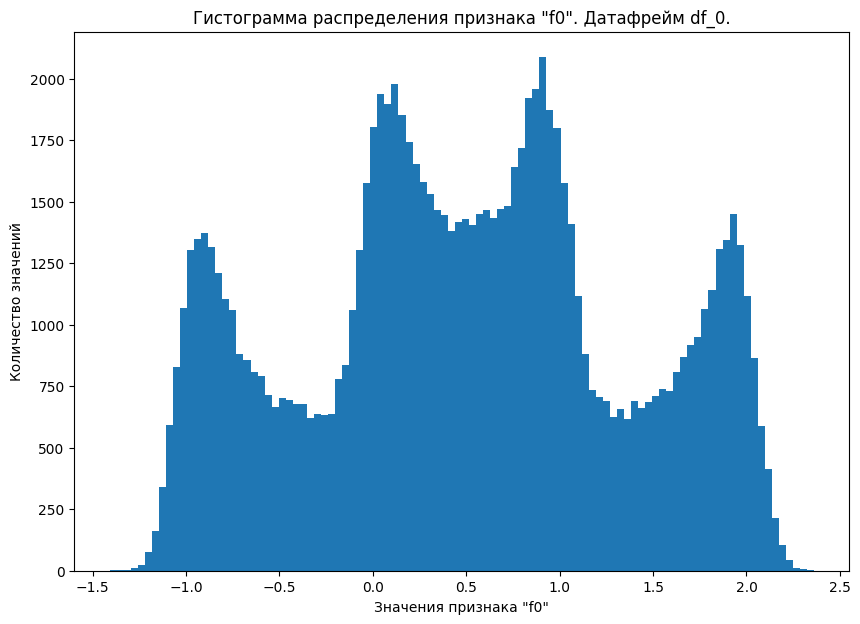

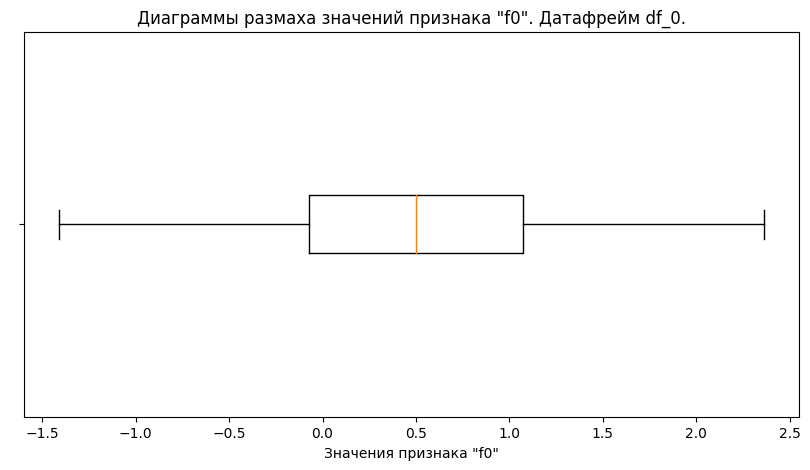

count    99980.000000
mean         0.500447
std          0.871879
min         -1.408605
25%         -0.072674
50%          0.502374
75%          1.073692
max          2.362331
Name: f0, dtype: float64


In [17]:
hist(col=df_0['f0'],
     bins=100,
     title='Гистограмма распределения признака "f0". Датафрейм df_0.',
     xlabel='Значения признака "f0"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f0". Датафрейм df_0.')

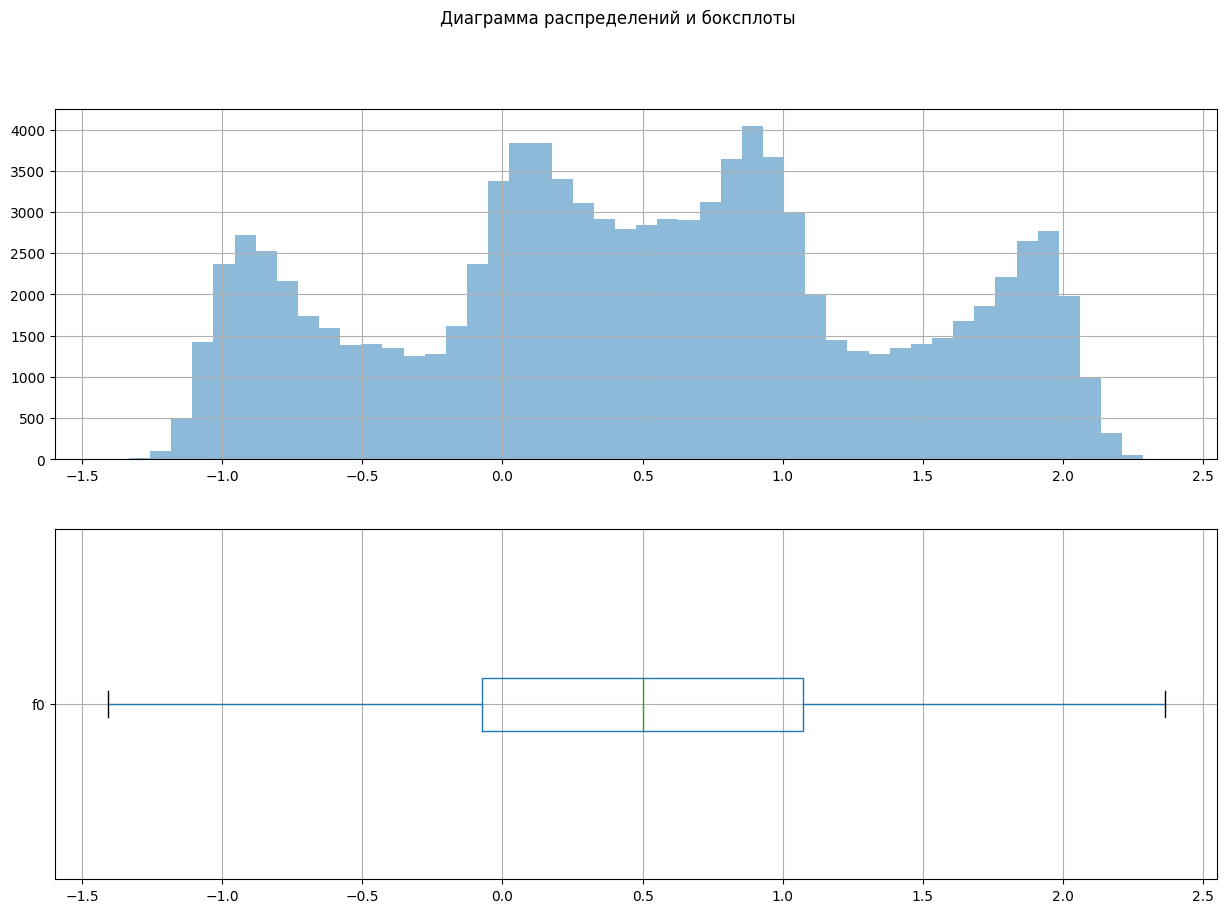

In [20]:
def plot_hist_boxplot(df, column, title = 'Диаграмма распределений и боксплоты', bins = [50, 50]):

    np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    axes[0].hist(df[column], bins = bins[0], alpha = 0.5)
    axes[0].grid()

    df.boxplot(column, ax = axes[1], vert = False)
    fig.suptitle(title)

    plt.show()

plot_hist_boxplot(df_0, 'f0')

**Вывод:**

- Данные распределены ненормально. На графике 4 вершины.
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (-1,4; 2,37) c медианой равной 0,50.

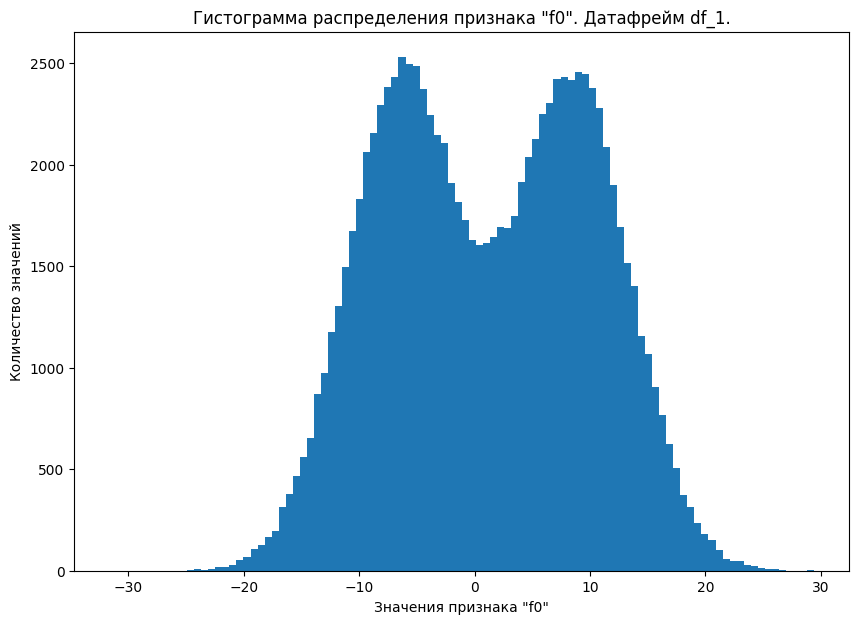

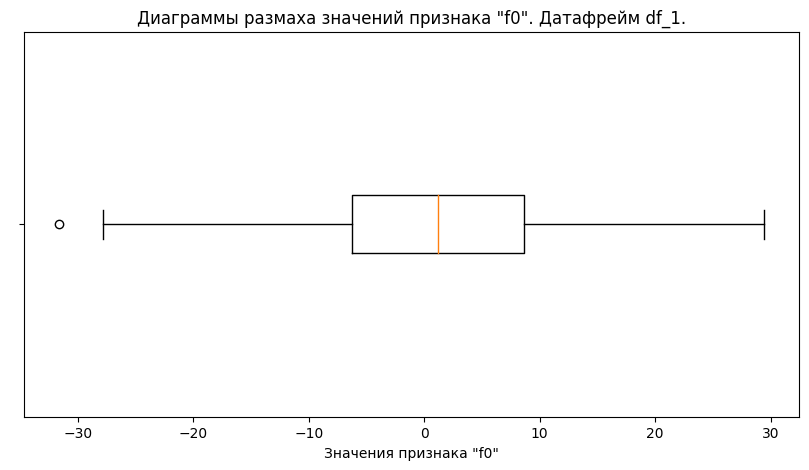

count    99992.000000
mean         1.141363
std          8.965805
min        -31.609576
25%         -6.298525
50%          1.153190
75%          8.620964
max         29.421755
Name: f0, dtype: float64


In [21]:
hist(col=df_1['f0'],
     bins=100,
     title='Гистограмма распределения признака "f0". Датафрейм df_1.',
     xlabel='Значения признака "f0"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f0". Датафрейм df_1.')

**Вывод:**

- Данные распределены ненормально. На графике 2 вершины.
- Обнаружен выброс в зоне отрицательных значений.
- Значения признака лежат в диапазоне (-31.60; 29.42) c медианой равной 1.15.

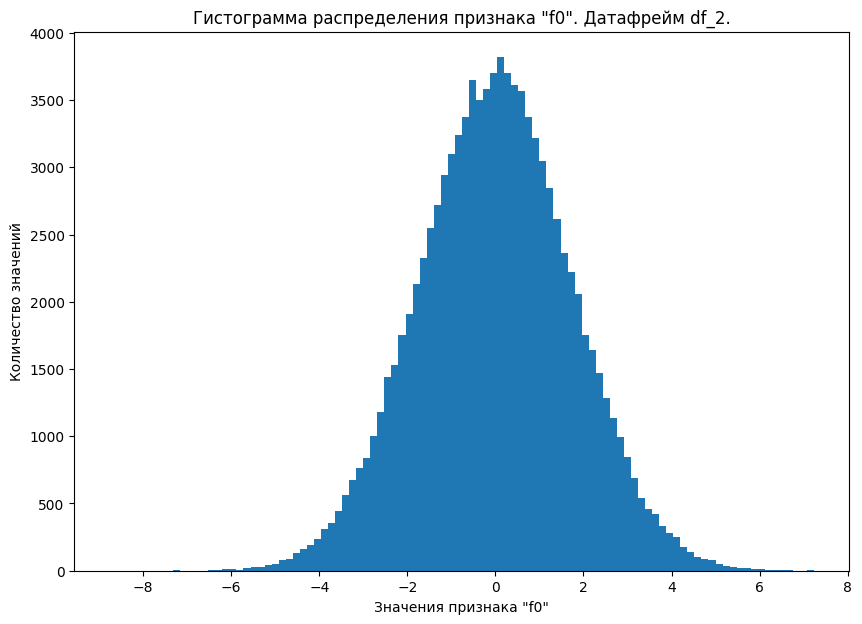

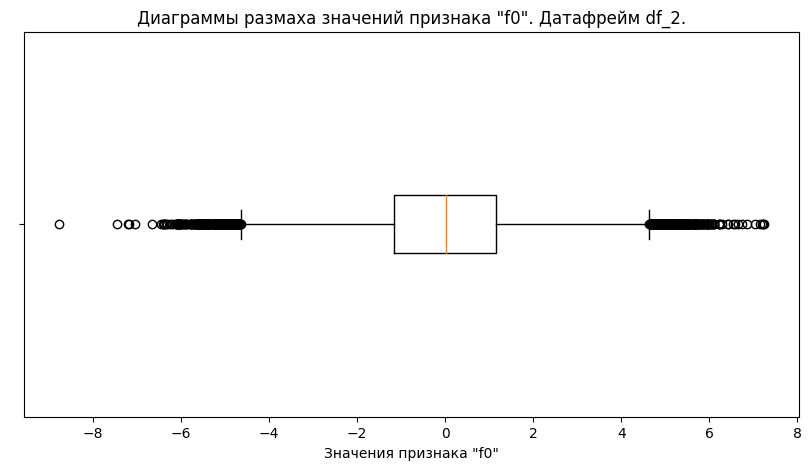

count    99992.000000
mean         0.001975
std          1.732061
min         -8.760004
25%         -1.162328
50%          0.009411
75%          1.158442
max          7.238262
Name: f0, dtype: float64


In [22]:
hist(col=df_2['f0'],
     bins=100,
     title='Гистограмма распределения признака "f0". Датафрейм df_2.',
     xlabel='Значения признака "f0"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f0". Датафрейм df_2.')

**Вывод:**

- Данные распределены нормально.
- Имеются многочисленные выбросы.
- Значения признака лежат в диапазоне (-8.76; 7.24) c медианой равной 0.01.

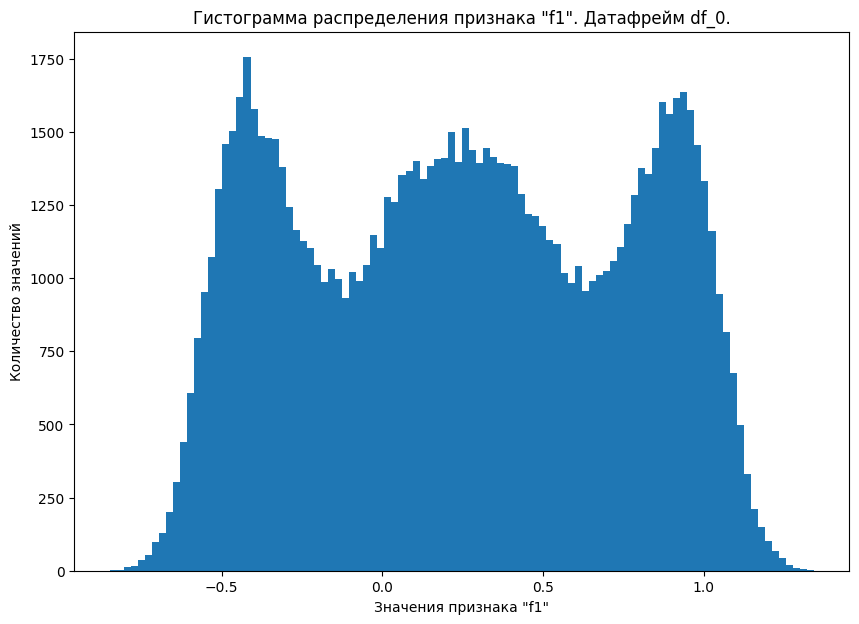

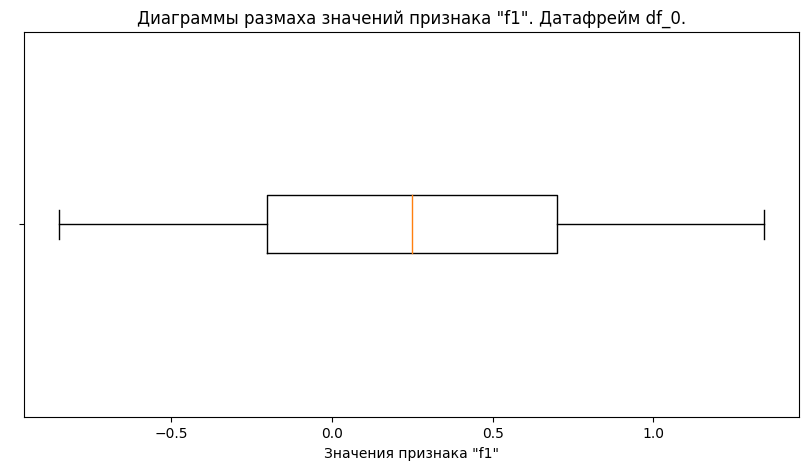

count    99980.000000
mean         0.250147
std          0.504431
min         -0.848218
25%         -0.200869
50%          0.250252
75%          0.700646
max          1.343769
Name: f1, dtype: float64


In [23]:
hist(col=df_0['f1'],
     bins=100,
     title='Гистограмма распределения признака "f1". Датафрейм df_0.',
     xlabel='Значения признака "f1"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f1". Датафрейм df_0.')

**Вывод:**

- Данные распределены ненормально. На графике 3 вершины.
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (-0.84; 1.34) c медианой равной 0.25.

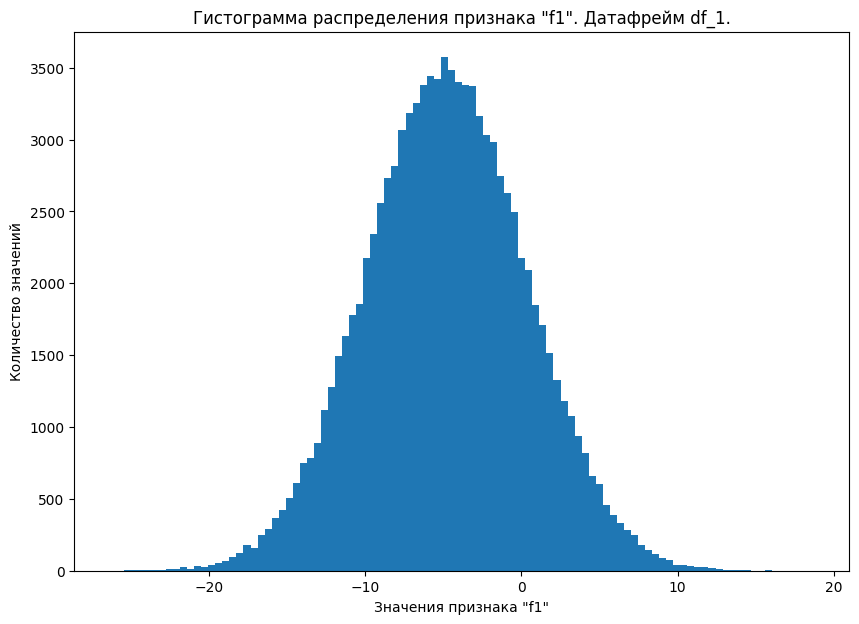

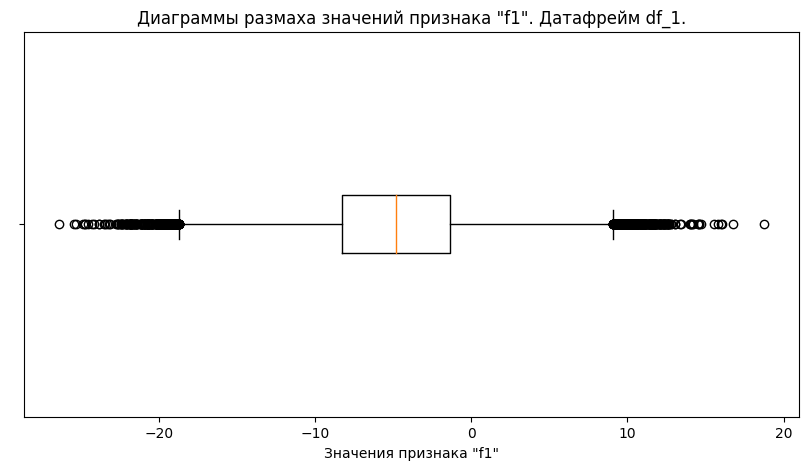

count    99992.000000
mean        -4.796522
std          5.119934
min        -26.358598
25%         -8.267985
50%         -4.813005
75%         -1.332704
max         18.734063
Name: f1, dtype: float64


In [24]:
hist(col=df_1['f1'],
     bins=100,
     title='Гистограмма распределения признака "f1". Датафрейм df_1.',
     xlabel='Значения признака "f1"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f1". Датафрейм df_1.')

**Вывод:**

- Данные распределены нормально.
- Имеются многочисленные выбросы.
- Значения признака лежат в диапазоне (-26.36; 18.73) c медианой равной -4.81.

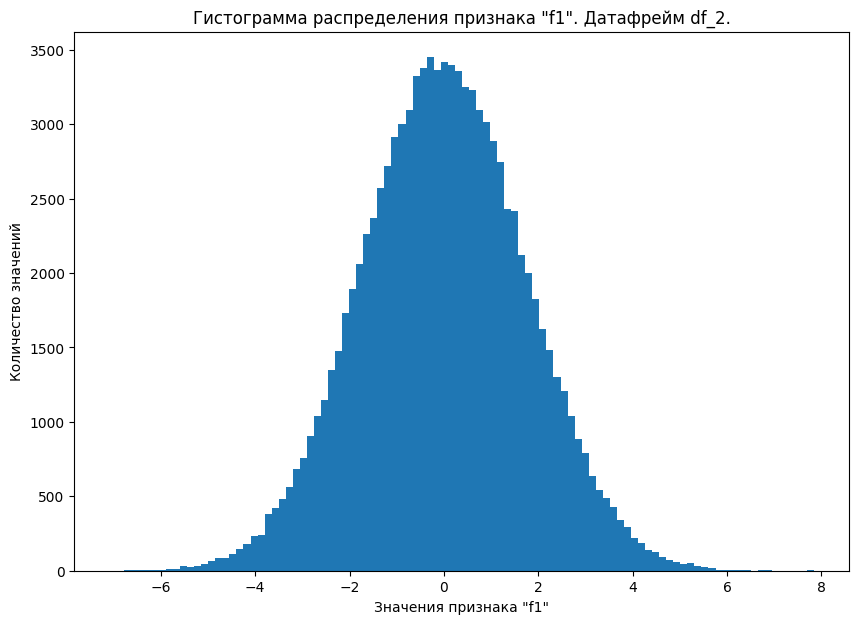

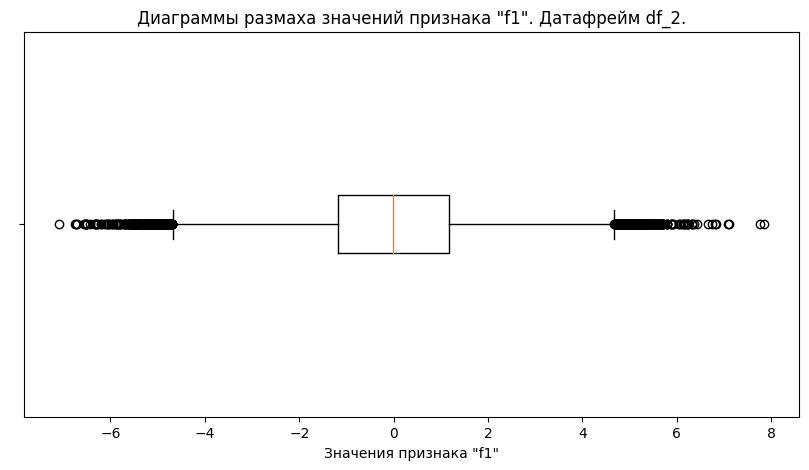

count    99992.000000
mean        -0.002113
std          1.730404
min         -7.084020
25%         -1.174820
50%         -0.009580
75%          1.163592
max          7.844801
Name: f1, dtype: float64


In [25]:
hist(col=df_2['f1'],
     bins=100,
     title='Гистограмма распределения признака "f1". Датафрейм df_2.',
     xlabel='Значения признака "f1"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f1". Датафрейм df_2.')

**Вывод:**

- Данные распределены нормально.
- Имеются многочисленные выбросы.
- Значения признака лежат в диапазоне (-7.08; 7.84) c медианой равной -0.01.

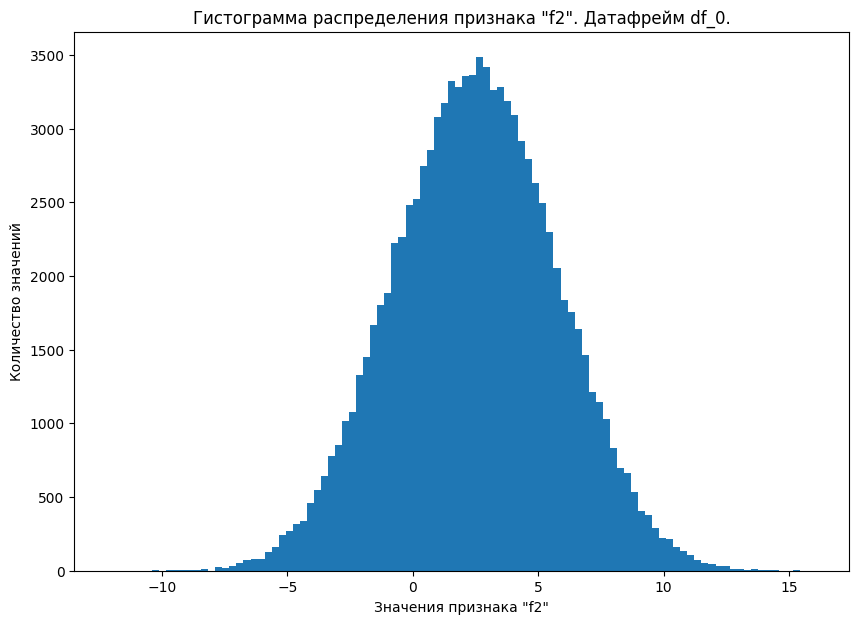

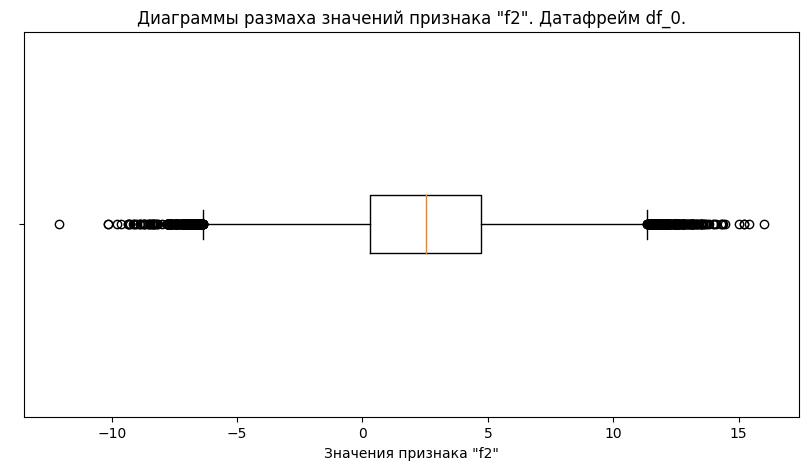

count    99980.000000
mean         2.502638
std          3.248056
min        -12.088328
25%          0.288010
50%          2.516005
75%          4.714884
max         16.003790
Name: f2, dtype: float64


In [26]:
hist(col=df_0['f2'],
     bins=100,
     title='Гистограмма распределения признака "f2". Датафрейм df_0.',
     xlabel='Значения признака "f2"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f2". Датафрейм df_0.')

**Вывод:**

- Данные распределены нормально.
- Имеются многочисленные выбросы.
- Значения признака лежат в диапазоне (-12.09; 16.00) c медианой равной 2.52.

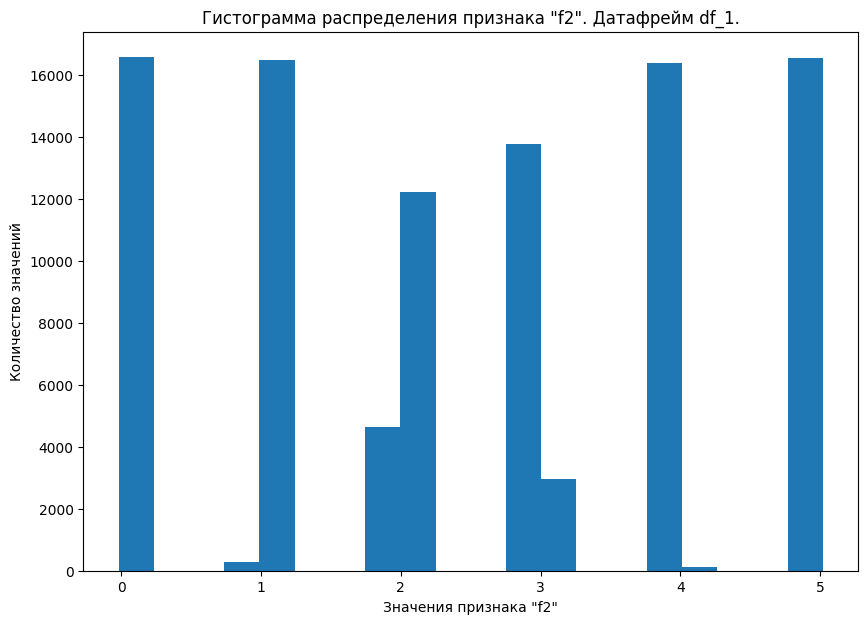

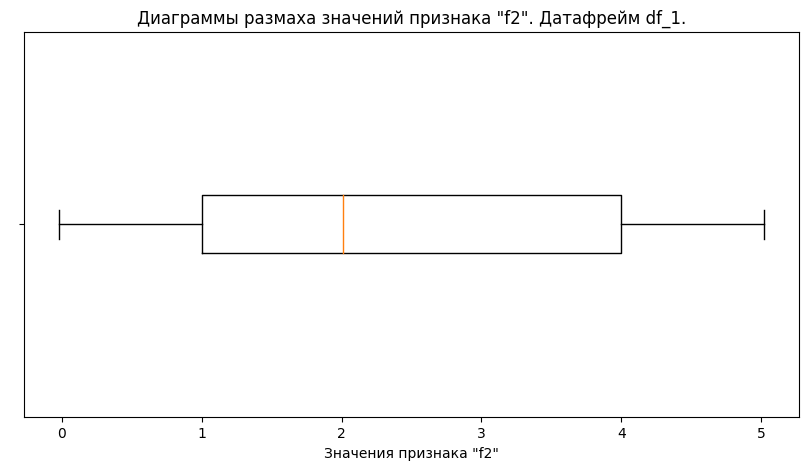

count    99992.000000
mean         2.494511
std          1.703587
min         -0.018144
25%          1.000021
50%          2.011475
75%          3.999904
max          5.019721
Name: f2, dtype: float64


In [27]:
hist(col=df_1['f2'],
     bins=20,
     title='Гистограмма распределения признака "f2". Датафрейм df_1.',
     xlabel='Значения признака "f2"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f2". Датафрейм df_1.')

**Вывод:**

- Данные распределены ненормально.
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (-0.02; 5.02) c медианой равной 2.01.

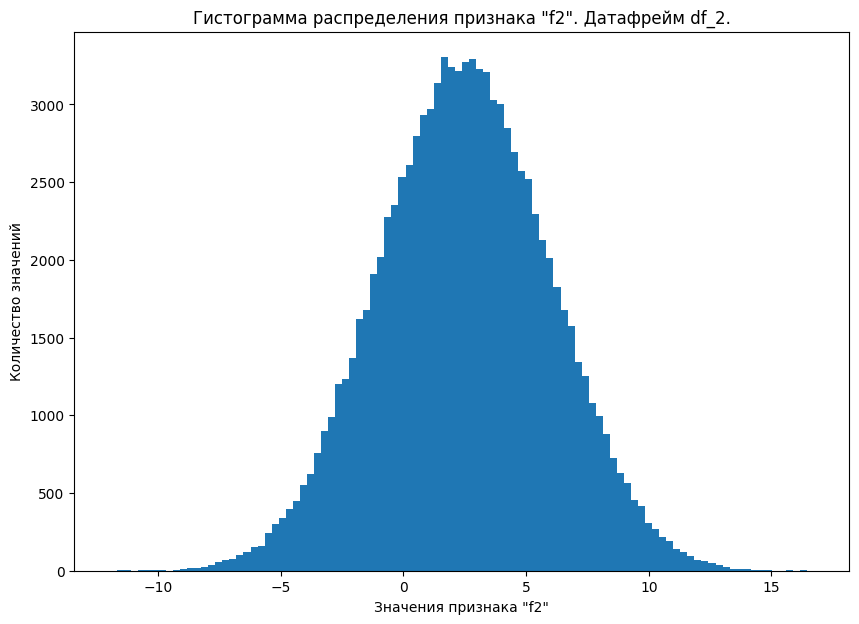

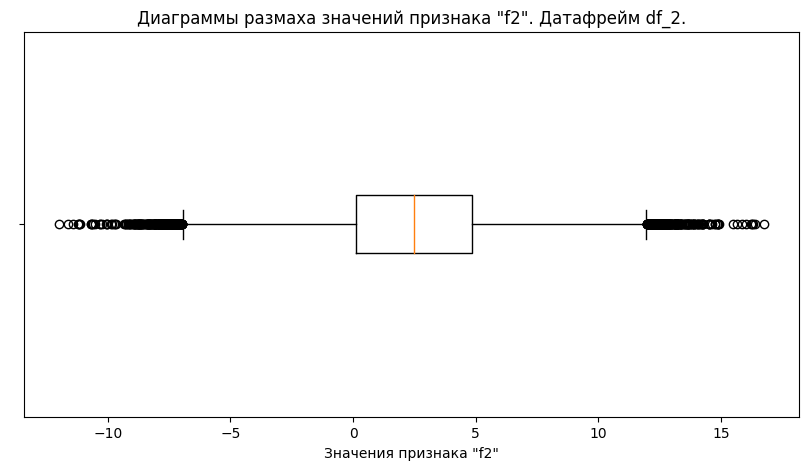

count    99992.000000
mean         2.495088
std          3.473491
min        -11.970335
25%          0.130269
50%          2.484236
75%          4.858662
max         16.739402
Name: f2, dtype: float64


In [28]:
hist(col=df_2['f2'],
     bins=100,
     title='Гистограмма распределения признака "f2". Датафрейм df_2.',
     xlabel='Значения признака "f2"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "f2". Датафрейм df_2.')

**Вывод:**

- Данные распределены нормально.
- Имеются многочисленные выбросы.
- Значения признака лежат в диапазоне (-11.97; 16.74) c медианой равной 2.48.

In [29]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


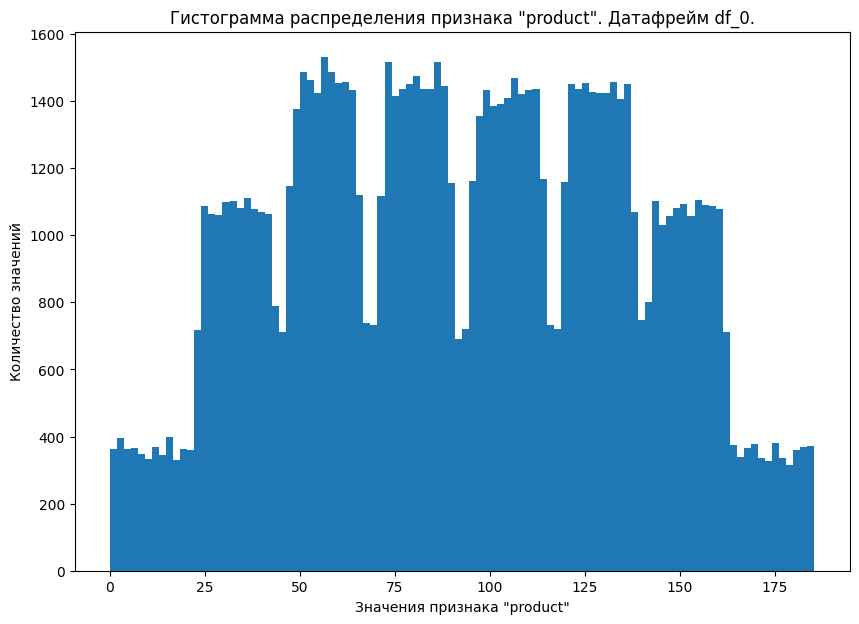

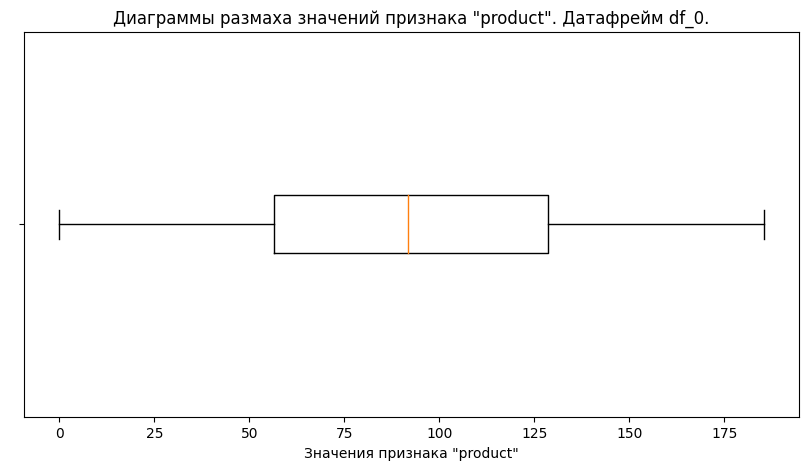

count    99980.000000
mean        92.499166
std         44.289044
min          0.000000
25%         56.496513
50%         91.847928
75%        128.564089
max        185.364347
Name: product, dtype: float64


In [30]:
hist(col=df_0['product'],
     bins=100,
     title='Гистограмма распределения признака "product". Датафрейм df_0.',
     xlabel='Значения признака "product"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "product". Датафрейм df_0.')

**Вывод:**

- Данные распределены ненормально. На графике наблюдаем множественные провалы (данные распределены неравномерно, на некоторых интервалах меньше наблюдений, чем на других).
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (0.00; 185.36) c медианой равной 91.84.

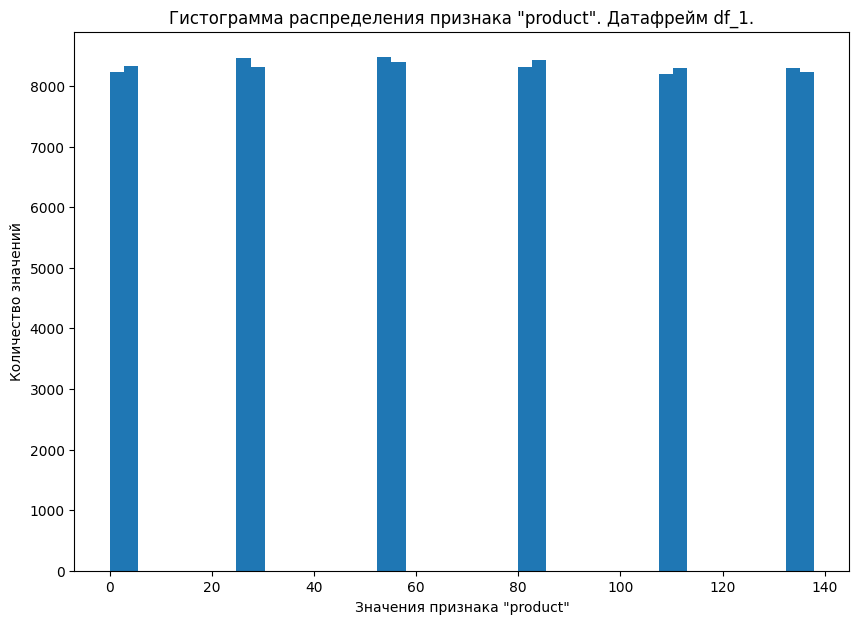

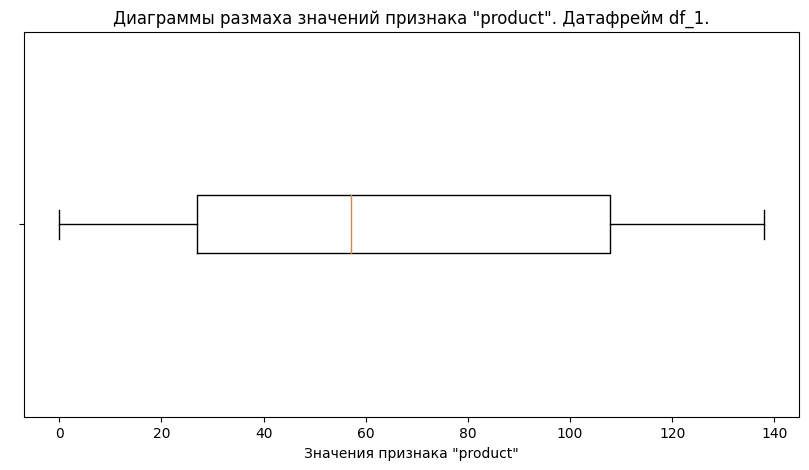

count    99992.000000
mean        68.824148
std         45.944889
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408
Name: product, dtype: float64


In [31]:
hist(col=df_1['product'],
     bins=50,
     title='Гистограмма распределения признака "product". Датафрейм df_1.',
     xlabel='Значения признака "product"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "product". Датафрейм df_1.')

**Вывод:**

- Данные распределены ненормально. 
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (0.00; 137.95) c медианой равной 57.09.

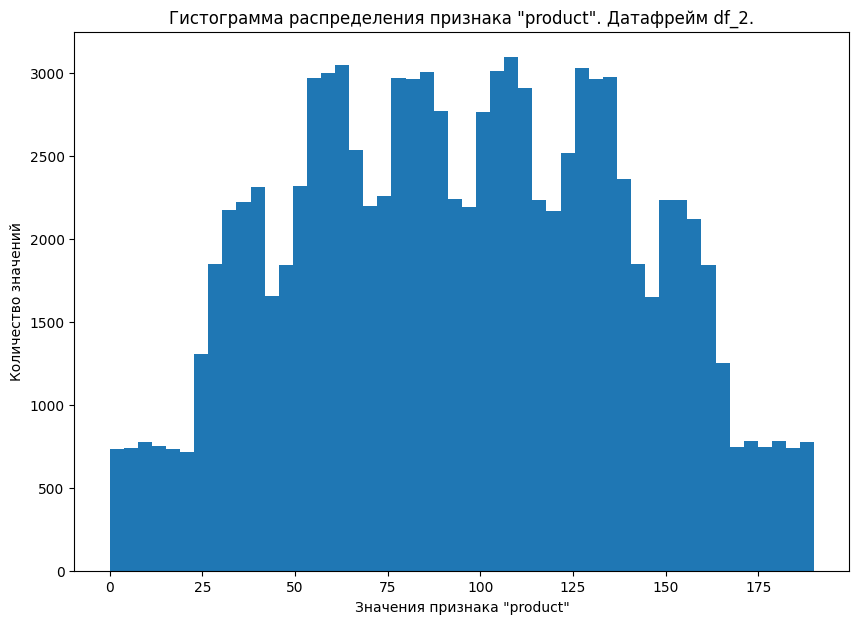

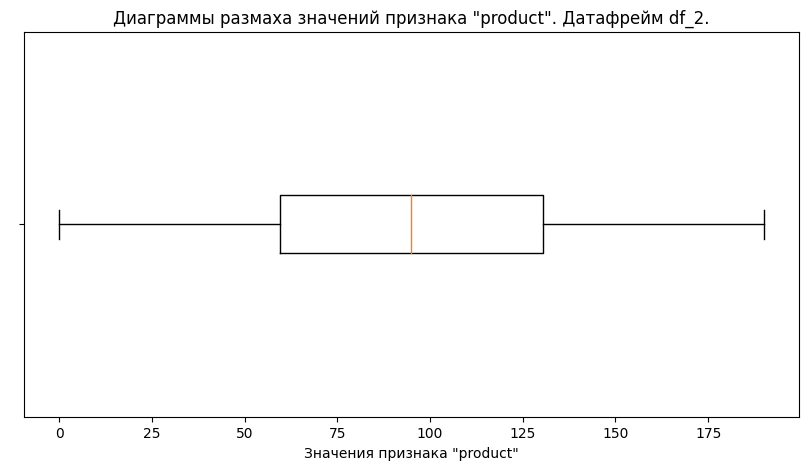

count    99992.000000
mean        94.998767
std         44.747763
min          0.000000
25%         59.450441
50%         94.925026
75%        130.585544
max        190.029838
Name: product, dtype: float64


In [32]:
hist(col=df_2['product'],
     bins=50,
     title='Гистограмма распределения признака "product". Датафрейм df_2.',
     xlabel='Значения признака "product"',
     ylabel='Количество значений',
     size_x=10,
     size_y=7,
     box_title='Диаграммы размаха значений признака "product". Датафрейм df_2.')

**Вывод:**

- Данные распределены ненормально. На графике наблюдаем множественные провалы (данные распределены неравномерно, на некоторых интервалах меньше наблюдений, чем на других).
- Выбросов не обнаружено.
- Значения признака лежат в диапазоне (0.00; 190.03) c медианой равной 94.93.

**Итог:**

- Большинство признаков не имеют нормального распределения. 
- Значительное число выбросов обнаружено:
  - `df_0['f2']`;
  - `df_1['f1']`;
  - `df_2['f0']`, `df_2['f1']`, `df_2['f2']`.

### Анализ зависимостей признаков

Построим матрицы рассеяния для визуальной оценки зависимостей между признаками для каждого датафрейма.

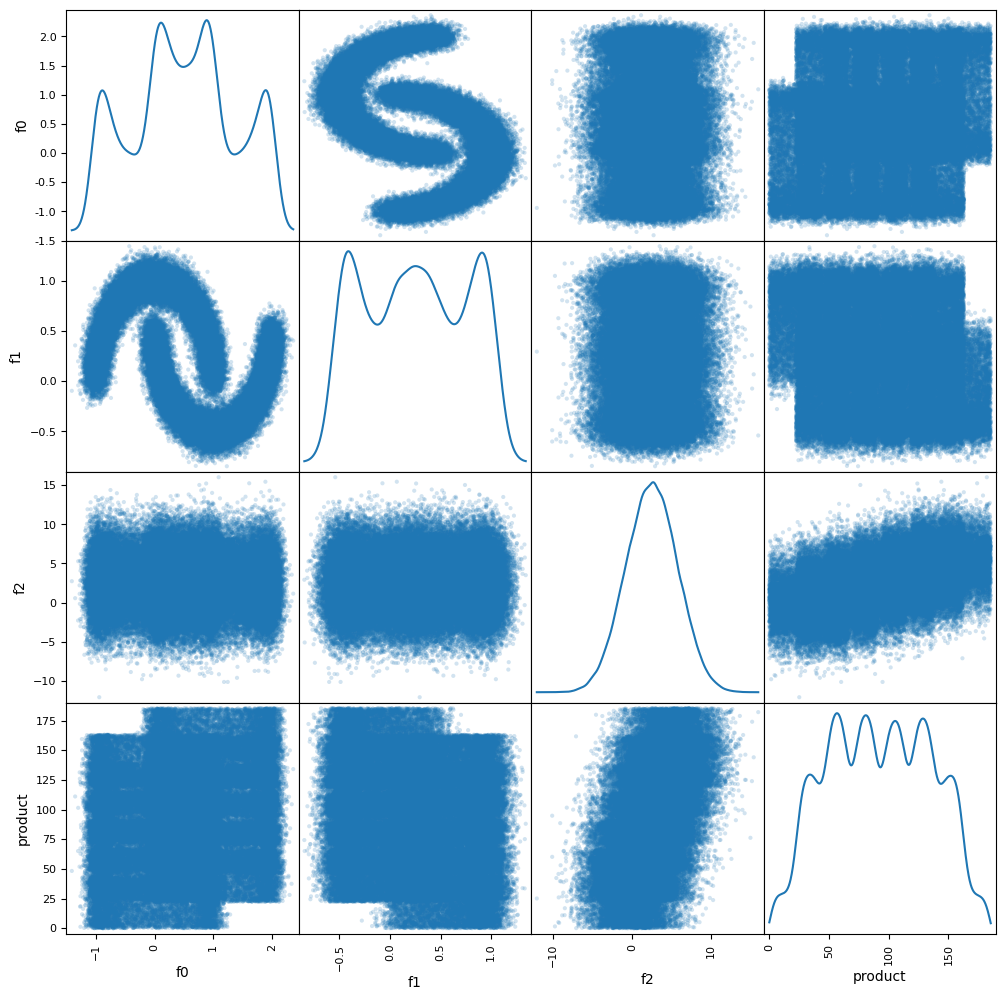

In [33]:
# матрица рассеяния для признаков датафрейма df_0
scatter_matrix(df_0[['f0', 'f1', 'f2', 'product']], alpha = 0.2, figsize=(12, 12), diagonal = 'kde')
plt.show()

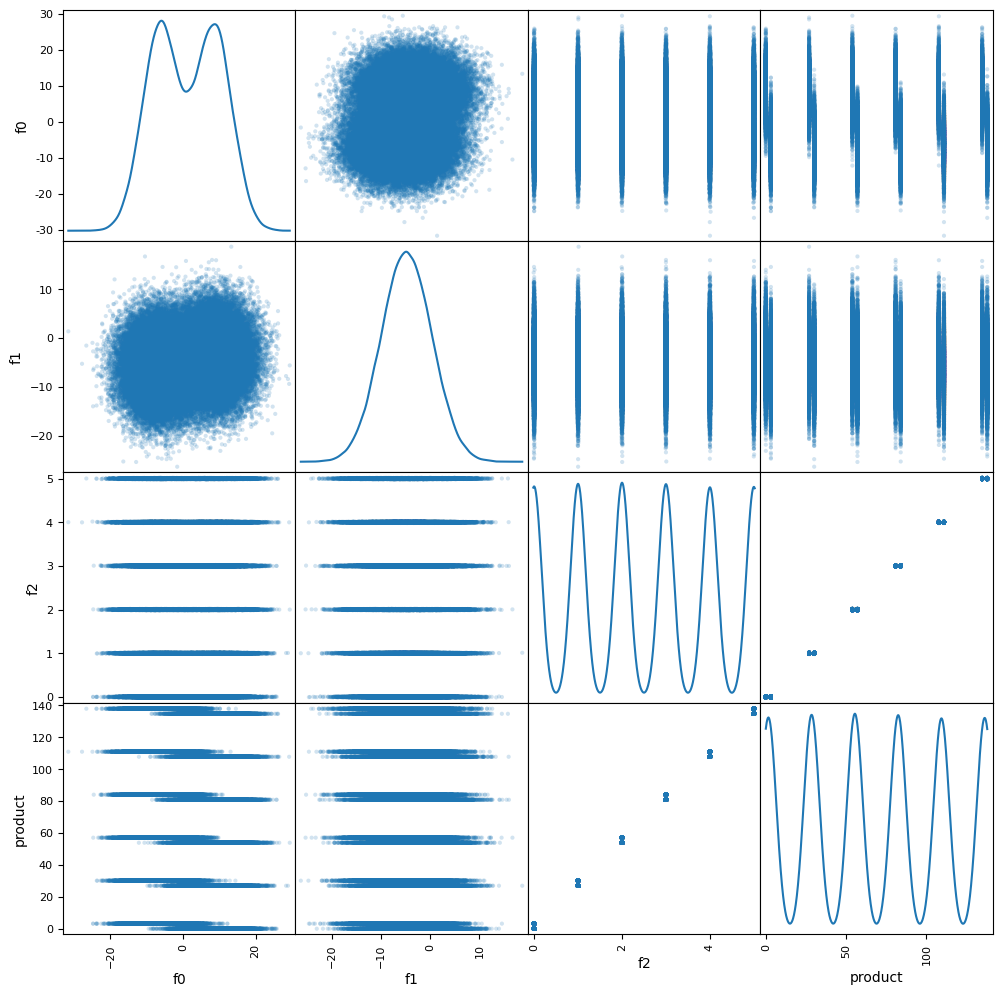

In [34]:
# матрица рассеяния для признаков датафрейма df_1
scatter_matrix(df_1[['f0', 'f1', 'f2', 'product']], alpha = 0.2, figsize=(12, 12), diagonal = 'kde')
plt.show()

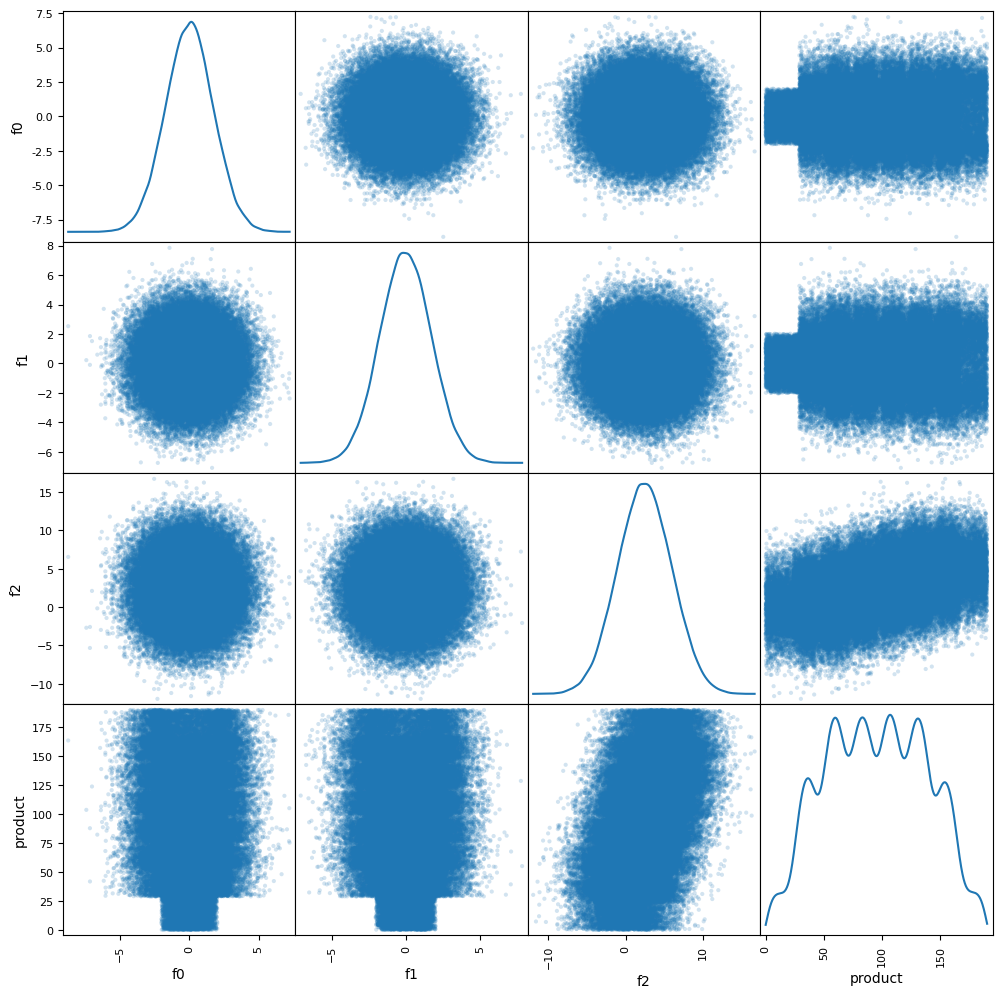

In [35]:
# матрица рассеяния для признаков датафрейма df_2
scatter_matrix(df_2[['f0', 'f1', 'f2', 'product']], alpha = 0.2, figsize=(12, 12), diagonal = 'kde')
plt.show()

**Вывод:**

- На всех рассмотренных матрицах рассеяния линейная зависимость прослеживается между признаками `f2` и `product`. Зависимости между остальными признаками либо нелинейные, либо отсутствуют.

## Корреляционный анализ

Построим матрицы корреляции для признаков датафреймов `df_0`, `df_1`, `df_2` с помощью библиотеки `phik`.

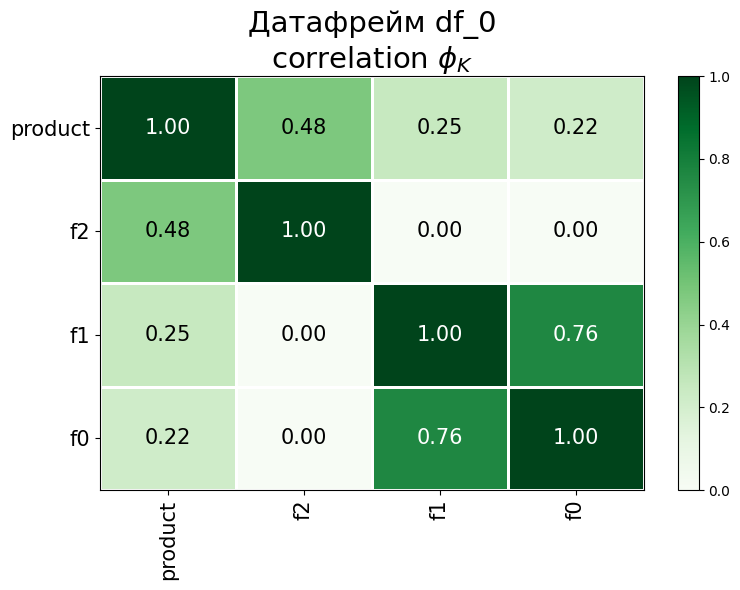

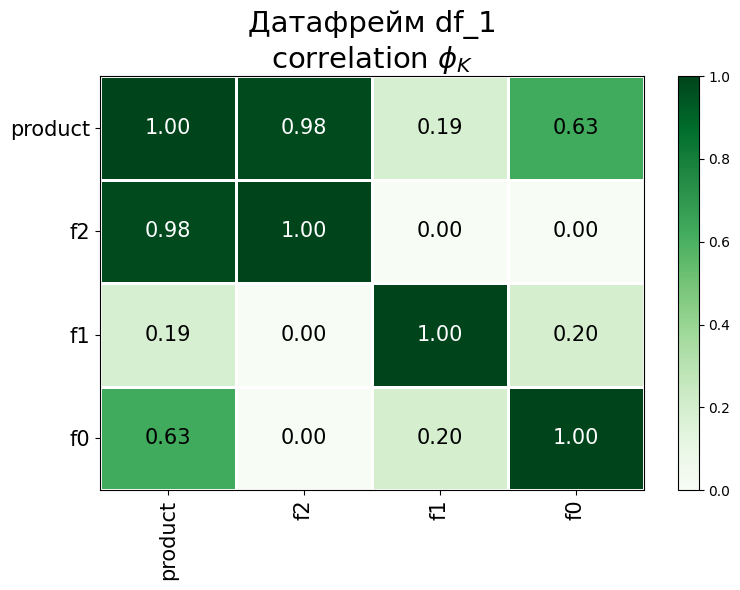

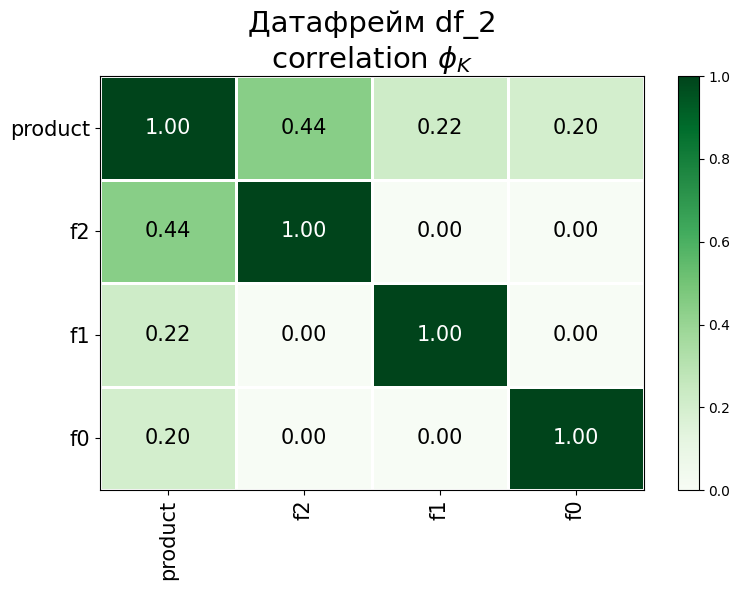

In [36]:
# создадим функцию для извлечения имени датафреймов из списка
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# создаём список с наименованиями непрерывных признаков
interval_cols = ['f0', 'f1', 'f2', 'product']

for i in [df_0, df_1, df_2]:   
    # считаем корреляции df_0
    phik_overview = phik_matrix(i.loc[:, i.columns != 'id'], interval_cols=interval_cols) 
    
    # строим матрицу
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='Greens',
        title=f'Датафрейм {get_df_name(i)}\ncorrelation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(8, 6))
    plt.show()

**Вывод:**

- В датафрейме `df_1` обнаружена весьма высокая положительная корреляция между признаками `f2` и `product` = 0,98. Высока вероятность мультиколлинеарности. Учтём это при построении модели машинного обучения.
- Корреляция между остальными признаками не является столь высокой, чтобы предположить наличие мультиколлинеарности.

## Обучение и проверка модели

Для каждого региона обучим и проверим модель линейной регрессии.
- Входные признаки: `f0`, `f1`, `f2`.
- Целевой признак: `product`.
- Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
- Все признаки являются количественными, масштабируем их при помощи StandardScaler().

In [37]:
# создадим списки для метрик, функция для каждой модели будет добавлять туда метрики
# затем из списков сформируем сравнительную таблицу метрик
R2_list, MAE_list, MSE_list, RMSE_list, mean_product_pred_list, avg_residuals_list = [], [], [], [], [], []

In [38]:
# создадим функцию для расчета линейной регрессии
# в качестве аргументов принимаем:
# "df" - имя датафрейма.
# "alpha" - если параметр задан, то вычисляется доверительный интервал прогноза с заданной обеспеченностью alpha

def lin_reg(df, alpha=False):
    
    # удалим из данных столбцы, которые не будем использовать для обучения модели
    X = df.drop(['id', 'product'], axis=1) # входные признаки
    y = df['product']                      # целевой признак
    
    # разделим данные на тренировочные и валидационные, зафиксируем random_state
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE)
    
    ## Масштабирование признаков ---------------------------------------------------
    # создаём переменную с экземпляром класса StandartScaler()
    scaler = StandardScaler()
    
    # обучим и трансформируем количественные признаки из тренировочной выборки, 
    # преобразуем тестовую выборку
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # создаём тренировочный и валидационный датафреймы из отмасштабированных данных    
    X_train = pd.DataFrame(X_train_scaled)
    X_test = pd.DataFrame(X_test_scaled)
    
    #return X_train, X_test, y_train, y_test
    ## обучение модели линейной регрессии------------------------------------------
    
    # инициализируем модель линейной регрессии
    model_lr = LinearRegression() 
    
    # обучим модель на тренировочных данных
    model_lr.fit(X_train, y_train) 
    
    # получим предсказания модели на валидационных данных 
    # сохраним результат в переменную predictions
    predictions = model_lr.predict(X_test) 
    
    # сформируем датафрейм с ответами и предсказаниями на валидационной выборке
    val_pred = y_test.to_frame(name='y_valid')
    val_pred['y_pred'] = predictions
    
    ## метрики и показатели-----------------------------------------------------------------
    # каждое значение запишем в список для сравнительной таблицы
    
    R2 = r2_score(y_test, predictions).round(2)
    print("R2 LinearRegression =", R2)
    R2_list.append(R2)
    
    MAE = mean_absolute_error(y_test, predictions).round(2)
    print("MAE LinearRegression =", MAE)
    MAE_list.append(MAE)
    
    MSE = mean_squared_error(y_test, predictions).round(2)
    print("MSE LinearRegression =", MSE) 
    MSE_list.append(MSE)
    
    RMSE = mean_squared_error(y_test, predictions, squared=False).round(2)
    print("RMSE LinearRegression =", RMSE)
    RMSE_list.append(RMSE)
    
    # рассчитаем и выведем ср. запас предсказанного сырья
    mean_product_pred = predictions.mean().round(2)
    print("Средний запас предсказанного сырья на валидационной выборке =", 
          mean_product_pred, "тыс. баррелей")
    mean_product_pred_list.append(mean_product_pred)

    ## анализ остатков------------------------------------------------------------
    
    # рассчитаем остатки
    residuals = y_test - predictions
    
    # построим графики по количественным признакам — гистограмму частотности 
    # распределения и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=20)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    
    axes[1].scatter(predictions, residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    
    plt.show()
    
    # вычислим среднее значение остатков
    avg_residuals = residuals.mean().round(2)
    print('Среднее значение остатков:', avg_residuals)
    
    # добавим среднее значение остатков в список для сравнительной таблицы
    avg_residuals_list.append(avg_residuals)
    
    ## вычислим доверительный интервал прогноза-----------------------------------
    if alpha:
        print('\nДоверительный интервал прогноза:')
        print(get_conf_int(alpha, model_lr, X_train, y_train))
    
    # выведем данные
    return model_lr, val_pred


Регион 0
R2 LinearRegression = 0.27
MAE LinearRegression = 31.1
MSE LinearRegression = 1425.9
RMSE LinearRegression = 37.76
Средний запас предсказанного сырья на валидационной выборке = 92.29 тыс. баррелей


C:\Users\Anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


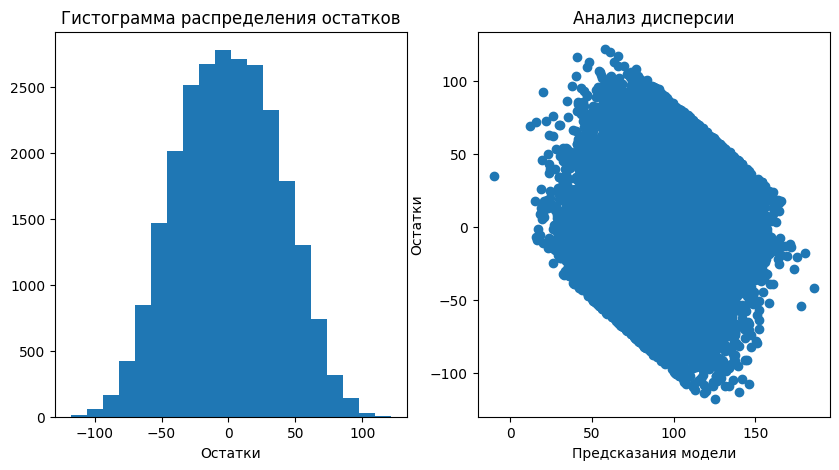

Среднее значение остатков: 0.09


Регион 1
R2 LinearRegression = 1.0
MAE LinearRegression = 0.72
MSE LinearRegression = 0.8
RMSE LinearRegression = 0.89
Средний запас предсказанного сырья на валидационной выборке = 69.17 тыс. баррелей


C:\Users\Anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


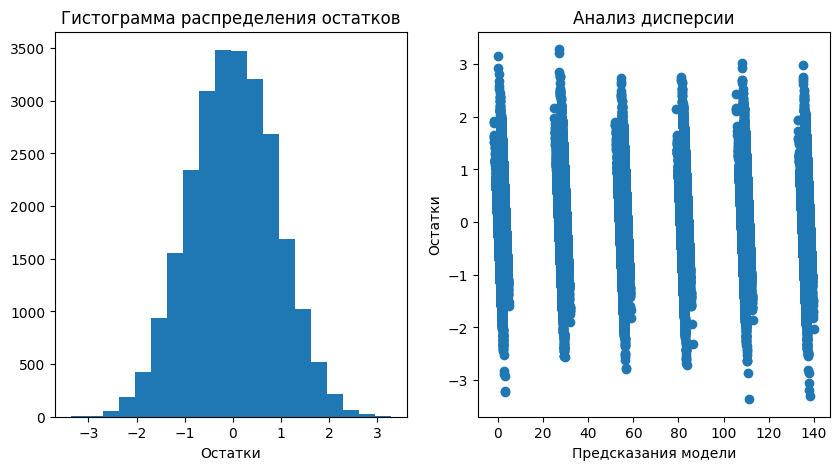

Среднее значение остатков: -0.0


Регион 2
R2 LinearRegression = 0.19
MAE LinearRegression = 32.86
MSE LinearRegression = 1610.51
RMSE LinearRegression = 40.13
Средний запас предсказанного сырья на валидационной выборке = 94.82 тыс. баррелей


C:\Users\Anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


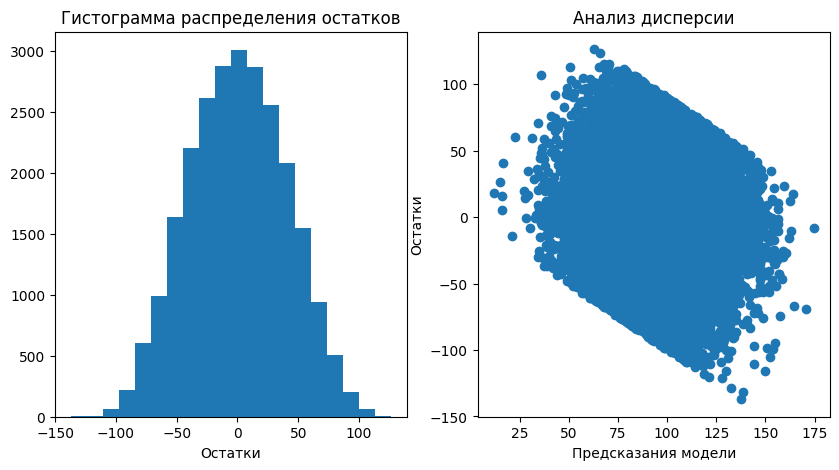

Среднее значение остатков: 0.24


In [39]:
# сохраним обученную модель в переменную и выведем результаты
# для каждого региона
print('\nРегион 0')
model_lr_0, val_pred_0 = lin_reg(df_0)

print('\n\nРегион 1')
model_lr_1, val_pred_1 = lin_reg(df_1)

print('\n\nРегион 2')
model_lr_2, val_pred_2 = lin_reg(df_2)

In [40]:
## создаем таблицу для сравнения моделей
# распределение остатков, вносим в список текст вручную
distribution_residuals = ['Нормальное',
                          'Нормальное',
                          'Нормальное',
                         ]

# дисперсия остатков, вносим в список текст вручную
variance_residuals = ['Линейная связь',
                      'Шесть зон ошибок',
                      'Линейная связь',
                     ]

data = [R2_list, 
        MAE_list, 
        MSE_list, 
        RMSE_list, 
        mean_product_pred_list,
        avg_residuals_list,
        distribution_residuals,
        variance_residuals,
       ]

columns = ['Регион 0', 'Регион 1', 'Регион 2'] 
index = ['R2', 
         'MAE', 
         'MSE', 
         'RMSE', 
         'Ср. запас предсказанного сырья на валид. выборке',
         'Среднее значение остатков',
         'Распределение остатков',
         'Дисперсия остатков',
         ]

metrics = pd.DataFrame(data, index, columns)
metrics

,Регион 0,Регион 1,Регион 2
R2,0.27,1.0,0.19
MAE,31.1,0.72,32.86
MSE,1425.9,0.8,1610.51
RMSE,37.76,0.89,40.13
Ср. запас предсказанного сырья на валид. выборке,92.29,69.17,94.82
Среднее значение остатков,0.09,-0.0,0.24
Распределение остатков,Нормальное,Нормальное,Нормальное
Дисперсия остатков,Линейная связь,Шесть зон ошибок,Линейная связь


**Вывод:**

- Прогнозы модели для регионов "0" и "1" являются недостаточно точными: R2 не превышает 0,27. Разбросы остатков не носят случайный характер, на графиках рассеивания прослеживаются линейные зависимости.

- Прогноз запасов сырья для региона "1" показывает метрику R2 = 1, что является слишком хорошим показателем и вызывает сомнения в корректности данных. Дисперсия остатков разделена на 6 участков, разброс не является случайным. Учитывая корреляцию 0,98 между признаком f2 и целевым, налицо утечка данных. 

На текущем этапе модель не готова к реальным прогнозам. Необходимо ввести дополнительные признаки, чтобы модель работала точнее, а также исключить утечку данных.

## Подготовка к расчёту прибыли

1. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины, исходя из следующих данных: 
- бюджет на разработку скважин в регионе — 10 млрд рублей;
- один баррель сырья приносит 450 рублей дохода, доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
2. Сравним полученный объём сырья со средним предсказанным запасом в каждом регионе. 

In [41]:
# объём сырья в скважине для безубыточной разработки, тыс. баррелей
min_vol_product = BUDGET / PRICE_THOUSAND_BARRELS / NUM_WELLS

print('Объём сырья в скважине для безубыточной разработки:', 
      round(min_vol_product, 2),
      'тыс. баррелей')

Объём сырья в скважине для безубыточной разработки: 111.11 тыс. баррелей


In [42]:
# cредние запасы сырья в скважинах по регионам
print('Средние предсказанные запасы в регионе 0:', mean_product_pred_list[0], 'тыс. баррелей')
print('Средние предсказанные запасы в регионе 1:', mean_product_pred_list[1], 'тыс. баррелей')
print('Средние предсказанные запасы в регионе 2:', mean_product_pred_list[2], 'тыс. баррелей')

Средние предсказанные запасы в регионе 0: 92.29 тыс. баррелей
Средние предсказанные запасы в регионе 1: 69.17 тыс. баррелей
Средние предсказанные запасы в регионе 2: 94.82 тыс. баррелей


**Вывод:**

Средние предсказанные запасы сырья в скважине в каждом регионе меньше требуемых для безубыточной разработки, поэтому мы не можем вести добычу в случайно выбранных скважинах. Необходимо выбрать лучшие скважины, используя нашу модель.

## Расчёт прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - выберем 200 скважины с максимальными значениями предсказаний;
 - просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
 - рассчитаем прибыль для полученного объёма сырья.

In [43]:
# создадим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели
# в качестве аргументов принимаем:
# "df" - имя датафрейма с предсказанными запасами: val_pred_0
# "num_wells", "price_thousand_barrels", "budget" - см. список констант (по аналогии)

def profit_calc(df, 
                num_wells=NUM_WELLS, 
                price_thousand_barrels=PRICE_THOUSAND_BARRELS, 
                budget=BUDGET):
    
    # выберем 200 лучших по предсказанным запасам скважин и 
    # суммируем фактические запасы
    sum_product = (df
                   .sort_values(by='y_pred', 
                                ascending=False)[:num_wells]['y_valid']
                   .sum())
    
    # выведем прибыль (в рублях)
    return (sum_product * price_thousand_barrels) - budget

**Вывод:**

Фукция для расчета прибыли готова, можно приступать к рассчету прибыли и рисков для каждого региона.

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Выберем регион для разработки скважин.

In [44]:
# создадим функцию для расчёта прибыли и риска для каждого региона
# на вход принимаем таблицу с предсказанными и фактическими 
# запасами по одному региону, например: val_pred_0
# а также функцию "profit_calc"
def profit_risk(data):
    
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        # отберём случайным образом 500 скважин
        subsample = data.sample(n=500, replace=True, random_state=state)
        
        # вычислим прибыль от разработки 200 лучших скважин из этой подвыборки
        # добавим прибыль в список
        values.append(profit_calc(subsample))
        
    # преобразуем список в объект Series
    values = pd.Series(values)
    
    # найдем среднюю прибыль (в рублях)
    avg_profit = values.mean()
    
    # Ищем 95%-й доверительный интервал (в рублях)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Средняя прибыль (млн. руб.):', (avg_profit/1000000).round(2))
    print('95%-й доверительный интервал (млн. руб.):', f'({(lower/1000000).round(2)}, {(upper/1000000).round(2)})')
    
    ## определяем вероятность убытка-----------------------------------------------
    # сортируем все значения по возрастанию и перезаписываем индексы (от 0 до 999)
    a = values.sort_values(ascending=True).reset_index(drop=True)
    
    # находим процент отрицательных чисел в списке values - это и есть вероятность убытка
    #loss_proba = (a[a > 0].index[0]-1)/len(values)*100
    loss_proba = (values < 0).sum()/len(values)*100
    print(f'Вероятность убытка: {loss_proba.round(2)} %')
    
    # построим прибыли и риска
    ax=(values/10**6).plot(
        kind='hist',
        label='Распределение прибыли',
        grid=False,
        bins=33,
        title = 'Гистограмма прибыли при разработке скважин',
    )
    plt.xlabel('Прибыль при разработке скважины, млн. руб.')
    plt.ylabel('Количество скважин')
    
    # вычисляем максимальное колочество по столбцам
    max_ = 0
    for i in ax.patches:
        height = i.get_height()
        if height > max_:
            max_ = height
    
    # строим вертикальные линии
    plt.vlines(x=[lower/10**6,upper/10**6, avg_profit/10**6],
               ymin=0, 
               ymax=max_,
               colors='r', 
               ls='--', 
               lw=2, 
               label='95%-й доверительный интервал')
    
    plt.axvline(avg_profit/10**6, 
                color='y', 
                ls='--', 
                lw=2, 
                label='Средняя прибыль')
    
    # выносим легенду за график
    plt.legend(bbox_to_anchor=(1.0, 1),
        loc='upper left')

    plt.show()

Рассчитаем прибыли и риски для каждого региона.

Регион 0:
Средняя прибыль (млн. руб.): 396.71
95%-й доверительный интервал (млн. руб.): (-101.79, 931.56)
Вероятность убытка: 7.2 %


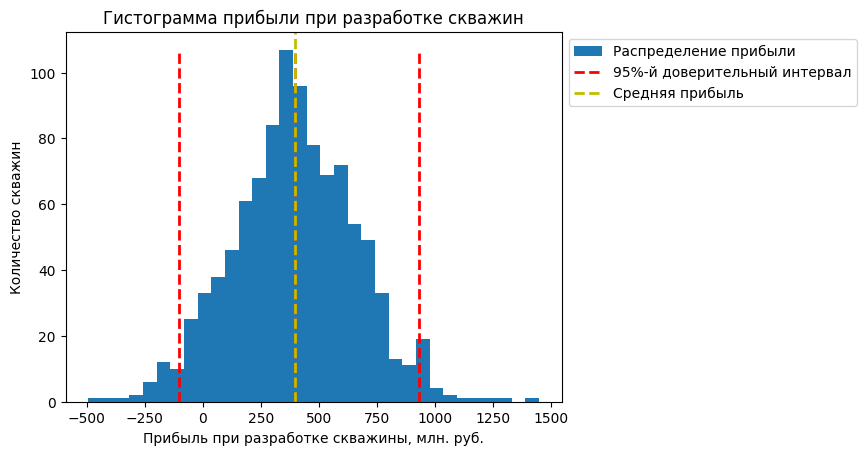


Регион 1:
Средняя прибыль (млн. руб.): 488.47
95%-й доверительный интервал (млн. руб.): (90.89, 894.38)
Вероятность убытка: 1.0 %


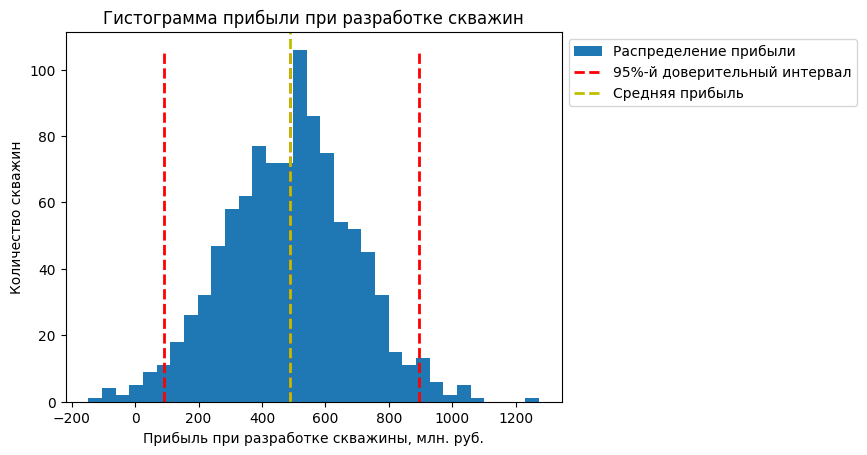


Регион 2:
Средняя прибыль (млн. руб.): 357.47
95%-й доверительный интервал (млн. руб.): (-120.49, 897.14)
Вероятность убытка: 7.3 %


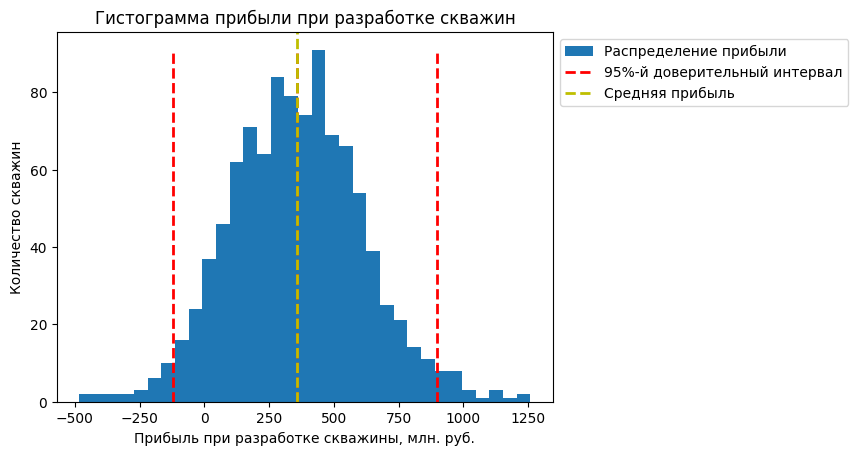

In [45]:
print('Регион 0:')
profit_risk(val_pred_0)

print('\nРегион 1:')
profit_risk(val_pred_1)

print('\nРегион 2:')
profit_risk(val_pred_2)

**Вывод:**

По имеющимся (синтетическим) данным наиболее привлекательным является Регион 1:
- показатель средней прибыли максимальный по сравнению с другими регионами;
- в 95%-й интервал попадают только положительные значения прибыли;
- вероятность убытка в районе 1%.

На втором месте по привлекательности - Регион 0. Но для этого региона вероятность убытка значительно выше - 7,2%.

## Выводы

В данном проекте было необходимо выбрать место для бурения скважины.

**В ходе проекта мы провели следующую работу:**
- изучили данные, проверили их на предмет аномалий и несоответствий;
- произвели предобработку для последующего анализа: проверили их на пропуски и дубликаты, обработали дубликаты;
- произвели исследовательский анализ признаков и их зависимостей; 
- Произвели корреляционный анализ признаков;
- для каждого региона обучили модель линейной регрессии;
- произвели анализ результатов работы модели.
- рассчитали прибыль и финансовые риски добычи для каждого рассматриваемого региона. 

**Результаты:**

- Прогнозы модели для регионов "0" и "1" являются недостаточно точными: R2 не превышает 0,27. Разбросы остатков не носят случайный характер, на графиках рассеивания прослеживаются линейные зависимости.

- Прогноз запасов сырья для региона "1" показывает метрику R2 = 1, что является слишком хорошим показателем и вызывает сомнения в корректности данных. Дисперсия остатков разделена на 6 участков, разброс не является случайным. Учитывая корреляцию 0,98 между признаком f2 и целевым, налицо утечка данных. 

По имеющимся (синтетическим) данным наиболее привлекательным является Регион 1:
- показатель средней прибыли максимальный по сравнению с другими регионами;
- в 95%-й интервал попадают только положительные значения прибыли;
- вероятность убытка в районе 1%.
На втором месте по привлекательности - Регион 0. Но для этого региона вероятность убытка значительно выше - 7,2%.

Блок с расчётом прибыли и рисков уже можно использовать в реальном рассчете.
  
**Рекомендации:**

В исходных данных в значениях столбцов `'id'` обнаружены дубликаты во всех 3-х таблицах. Необходимо исправить данные или дать пояснения.

На текущем этапе модель не готова к реальным прогнозам. Для корректной работы модели необходимо следующее:
- ввести дополнительные признаки, чтобы модель работала точнее; 
- исключить утечку данных.